In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler


from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

from tqdm import tqdm
import pandas as pd

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [6]:
# Load collection
repo = '/repo/main'
instrument = "LSSTComCam"

butler_11= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_11/DM-49472', instrument=instrument)
butler_12= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/d_2025_03_25/DM-49693', instrument=instrument)
butler_13= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_13/DM-49751', instrument=instrument)
butler_14= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_14/DM-49864', instrument=instrument)
butler = dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/v29_0_0_rc6/DM-50098', instrument=instrument)

In [7]:
obj_refs = butler.query_datasets("object")

print(len(obj_refs))

29


In [8]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold diaObj and diaSource DataFrames
Obj_list = []


# Loop through the specified tracts and fetch the data
for idx in tqdm(tract_indices):
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    Object_tract = butler.get(obj_ref)  # Fetch diaObj for this tract 
    Object_tract = Object_tract.to_pandas()  # Convert to DataFrame   
    # Append the results to the lists
    Obj_list.append(Object_tract)

# Concatenate all diaObj and diaSource DataFrames
combined_Obj = pd.concat(Obj_list, ignore_index=False)



100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


In [9]:
combined_Obj = combined_Obj[(combined_Obj['g_ra']>50) & (combined_Obj['g_ra']<63)]

In [10]:
comcam_sne = pd.read_csv('comcam_sne.csv',names=['name', 'ra', 'dec'], header=None)

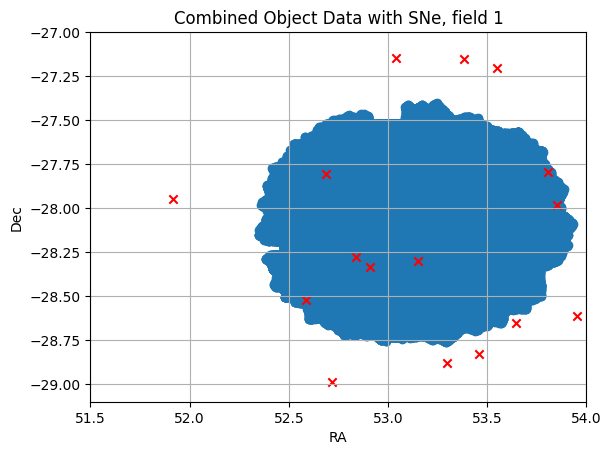

In [11]:
plt.scatter(combined_Obj['g_ra'], combined_Obj['g_dec'])
plt.scatter(comcam_sne['ra'], comcam_sne['dec'], color='red', marker='x')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Combined Object Data with SNe, field 1')
plt.xlim(51.5, 54)
plt.ylim(-29.1, -27)
plt.grid()
plt.show()

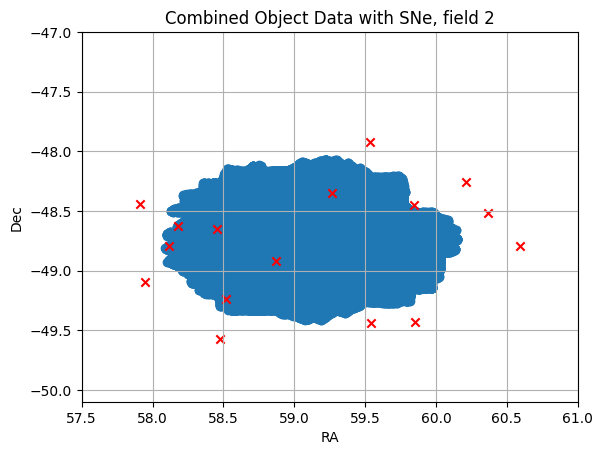

In [12]:
plt.scatter(combined_Obj['g_ra'], combined_Obj['g_dec'])
plt.scatter(comcam_sne['ra'], comcam_sne['dec'], color='red', marker='x')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Combined Object Data with SNe, field 2')
plt.xlim(57.5, 61)
plt.ylim(-50.1, -47)
plt.grid()
plt.show()

In [13]:
import lsdb

In [15]:
sne_lsdb = lsdb.from_dataframe(comcam_sne, ra_col='ra', dec_col='dec')

In [33]:
sne_lsdb

,name,ra,dec
npartitions=1,,,
"Order: 0, Pixel: 8",string[pyarrow],double[pyarrow],double[pyarrow]


In [20]:
combined_Obj.columns

Index(['tract', 'patch', 'r_ra', 'r_dec', 'r_raErr', 'r_decErr',
       'r_ra_dec_Cov', 'r_psfFlux', 'r_psfFluxErr', 'r_free_psfFlux',
       ...
       'u_sersicFluxErr', 'y_sersicFluxErr', 'z_sersicFluxErr',
       'sersic_indexErr', 'sersic_n_eval_jac', 'sersic_n_iter',
       'sersic_chisq_reduced', 'sersic_unknown_flag', 'sersic_no_data_flag',
       'objectId'],
      dtype='object', length=1279)

In [27]:
combined_Obj_thin = combined_Obj[['objectId','coord_ra', 'coord_dec']]
combined_Obj_thin = combined_Obj_thin.rename(columns={'coord_ra': 'ra', 'coord_dec': 'dec'})
combined_Obj_thin

,objectId,ra,dec
0,591817699928047627,59.124396,-49.349988
1,591817699928047630,59.135613,-49.348442
...,...,...,...
96139,609789629800930692,53.052860,-28.295422
96140,609789629800930693,53.053646,-28.295363


In [28]:
obj_lsdb = lsdb.from_dataframe(combined_Obj_thin)

In [32]:
obj_lsdb

,objectId,ra,dec
npartitions=1,,,
"Order: 0, Pixel: 8",int64[pyarrow],double[pyarrow],double[pyarrow]


In [29]:
sne_obj_xmatch = sne_lsdb.crossmatch(obj_lsdb, radius_arcsec=0.1)

In [31]:
sne_obj_xmatch_computed = sne_obj_xmatch.compute()

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
2024ahzn,60.36688333333333,-48.51589166666667
2024ahxh,58.45505416666666,-48.65107777777778
2025efr,60.21437083333333,-48.260730555555554
2024ahwc,53.85345833333333,-27.98288333333333
2024aeyj,59.5316,-47.92468888888889
2024ahzm,58.18194583333333,-48.630272222222224
2024ahtp,58.119229166666656,-48.79749722222222
2025efu,60.594891666666655,-48.792991666666666
2025egc,59.263574999999996,-48.349672222222225
2024ahxm,51.91752083333333,-27.946872222222222
2024adon,53.45996249999999,-28.82738611111111
2024ahxv,59.54062083333333,-49.43626666666666
2025egz,59.84871666666666,-48.44846666666666
2022vtm,53.383062499999994,-27.154602777777775
2024ahwn,52.685316666666665,-27.807183333333334
2025ego,57.94811666666666,-49.09705833333334
2024ahyq,52.90686249999999,-28.33369722222222
2024ahyn,53.646245833333325,-28.655113888888888
2025egk,58.870787499999985,-48.92298888888889
2024ahuu,53.15265833333332,-28.298616666666668
2024ahzc,52.83825416666666,-28.279899999999998
2024ahst,58.52061666666666,-49.24156111111111
2024ahul,53.80612083333333,-27.7927
2024ahza,53.29867083333332,-28.87943611111111
2025egw,53.041675,-27.14548333333333
2025egl,59.85536249999999,-49.43301111111111
2025egs,53.548691666666656,-27.206097222222223
2024ahum,58.47711666666666,-49.577444444444446
2024ahuo,52.71615416666666,-28.990466666666666
2025egj,57.913404166666666,-48.445097222222216
2025ehg,52.58514583333333,-28.519927777777777
2025egq,53.95270416666666,-28.614255555555555


In [ ]:
2024ahul,53.80612083333333,-27.7927